In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import sklearn
import torchsort

In [2]:
# Read the data from the CSV file
data = pd.read_csv('train_data_combined.csv')

# Convert the 'Coordinates' and 'Order' columns from strings to actual arrays
data['Coordinates'] = data['Coordinates'].apply(ast.literal_eval)
data['Order'] = data['Order'].apply(ast.literal_eval)


In [3]:
def normalize(coords):
    # coords_string = row['Coordinates']
    # coords = ast.literal_eval(coords_string)
    scaler = sklearn.preprocessing.MinMaxScaler()
    coords = scaler.fit_transform(coords)
    return coords

data['Coordinates'] = data['Coordinates'].apply(normalize)


def dist_matrix(cords):
    return sp.spatial.distance.cdist(cords, cords)

data['distance_matrix'] = data['Coordinates'].apply(dist_matrix)
data.head()

for i in range(len(data['distance_matrix'])):
    current_cords = data['Coordinates'][i]
    current_order = data['Order'][i]
    id = data['Id'][i]
    # print(current_cords)
    tmp_dist = np.sum([np.sqrt((current_cords[current_order[j]]).dot(current_cords[current_order[j-1]])) for j in range(1,len(current_cords))])
    # print(tmp_dist)
    # data["Distance"][i] = tmp_dist

    data.loc[data['Id'] == id, 'Distance'] = tmp_dist

data.head()


,Id,Coordinates,Order,Distance,Time,distance_matrix
0,1,"[[0.0, 0.0], [0.7777777777777778, 0.9537572254...","[0, 4, 9, 18, 17, 11, 20, 19, 10, 7, 13, 1, 15...",16.728140,13.537999,"[[0.0, 1.2306872538023605, 1.234640485676661, ..."
1,2,"[[0.0, 0.0], [0.2727272727272727, 0.1587301587...","[0, 17, 1, 16, 12, 2, 6, 18, 15, 11, 3, 4, 10,...",16.587638,16.687000,"[[0.0, 0.31555574559775895, 0.9387830696579602..."
2,3,"[[0.0, 0.0], [0.46153846153846156, 0.428571428...","[0, 10, 18, 1, 11, 7, 4, 13, 12, 20, 6, 9, 16,...",17.408139,15.678530,"[[0.0, 0.629834280479433, 0.4738115061034553, ..."
3,4,"[[0.0, 0.0], [0.865079365079365, 0.07317073170...","[0, 9, 19, 10, 14, 16, 11, 7, 20, 17, 18, 12, ...",15.854547,16.803660,"[[0.0, 0.8681683384371383, 0.5257502820685432,..."
4,5,"[[0.0, 0.0], [0.0963855421686747, 0.9999999999...","[0, 15, 20, 12, 11, 17, 19, 6, 18, 2, 5, 3, 9,...",17.022070,17.877002,"[[0.0, 1.004634347779902, 0.8478336251124811, ..."


In [4]:
def stack(input):
    input = np.array(input)
    return np.hstack((input[:,0],input[:,1]))

data["Cords_stacked"] = data["Coordinates"].apply(stack)
data["results_stacked"] = data["Cords_stacked"]

tmp_cords = data["Coordinates"].to_numpy()
indices = data["Order"].to_numpy()

order_list = []
results_stacked = []
for i in range(len(data["Cords_stacked"])):
    index = np.array(indices[i], dtype=np.int64)
    tmp_cords = np.array(data["Coordinates"].to_numpy()[i])
    tmp_result =  np.hstack((np.array(tmp_cords[:,0])[index],np.array(tmp_cords[:,1])[index]))
    results_stacked.append(tmp_result)
    
    order_list.append(data["Order"][i])

results_stacked = np.array(results_stacked, dtype=np.float32)
order_list = np.array(order_list, dtype=np.float32)
order_list

array([[ 0.,  4.,  9., ..., 14.,  8., 21.],
       [ 0., 17.,  1., ..., 14., 20., 21.],
       [ 0., 10., 18., ..., 15.,  2., 21.],
       ...,
       [ 0.,  4.,  8., ..., 15.,  2., 21.],
       [ 0.,  8.,  9., ..., 13., 15., 21.],
       [ 0., 12.,  1., ...,  8., 15., 21.]], dtype=float32)

In [5]:
class ConvNet(nn.Module):
    def __init__(self, in_channels=1, conv1_out_channels=32, conv2_out_channels=64, fc1_out_features=128, hidden_size=256, output_size=22, additional_input_size=44):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, conv1_out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(conv1_out_channels, conv2_out_channels, kernel_size=3, stride=1, padding=1)
        
        # Calculate the size of the flattened layer after convolutions
        self.conv_output_size = conv2_out_channels * 22 * 22
        
        # The total input size for the first fully connected layer includes the additional input values
        self.fc1_input_size = self.conv_output_size + additional_input_size
        
        # Define fully connected layers
        self.fc1 = nn.Linear(self.fc1_input_size, fc1_out_features)
        self.fc2 = nn.Linear(fc1_out_features, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
            
    def forward(self, image, additional_input):
        # x = F.relu(self.conv1(image))
        # x = F.relu(self.conv2(x))
        # x = x.view(-1, self.conv_output_size)  # Flatten the tensor
        # x = torch.cat((x, additional_input), dim=1)  # Concatenate additional input values
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))

        x = F.relu(self.conv1(image))
        x = F.relu(self.conv2(x))
        x = x.view(-1, self.conv_output_size)  # Flatten the tensor
        x = torch.cat((x, additional_input), dim=1)  # Concatenate additional input values
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = torchsort.soft_rank(x, regularization_strength=0.1) - 1
        # x = torch.clamp(x,0,1)
        return x

In [6]:
class CustomLossFunction(nn.Module):
    def __init__(self):
        super(CustomLossFunction, self).__init__()

    def forward(self, predictions, targets):
        # ordered_predictions = torchsort.soft_rank(predictions, regularization_strength = 0.01)
        loss = torch.sum(torch.square(predictions - targets)) / predictions.size(0)
        # loss = F.cross_entropy(predictions, targets)
        return loss

In [7]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f'Using device: {device}')

# input_cords = data['Cords_stacked'].to_numpy()
input_coordinates = []
for i in range(len(data["Cords_stacked"])):
    input_coordinates.append(data["Cords_stacked"][i])

input_coordinates = np.array(input_coordinates, dtype=np.float32)

# distance_matrices = np.array(data['distance_matrix'].to_numpy())
distance_matrices = []
tmp_distances = []
for i in range(len(data["distance_matrix"])):
    distance_matrices.append([data["distance_matrix"][i]])
    tmp_distances.append(data["Distance"][i])
    
distance_matrices = np.array(distance_matrices, dtype=np.float32)
tmp_distances = np.array(tmp_distances, dtype=np.float32)
tmp_distances


Using device: cuda


array([16.72814 , 16.587637, 17.408138, ..., 16.054285, 16.451767,
       16.676153], dtype=float32)

Epoch 250, Loss: 69.61213684082031
[ 0 16 16  5 13 14  1  5  6  9 18  6 12 18  3  5 13 11  2 19 10 21]


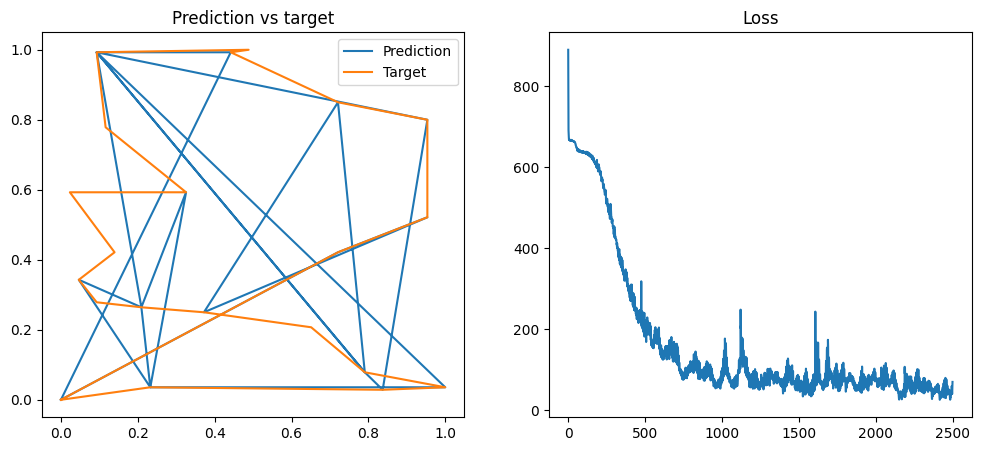

In [28]:
model = ConvNet(in_channels=1, conv1_out_channels=32, conv2_out_channels=64, fc1_out_features=128, output_size=22, additional_input_size=44, hidden_size=128*4).to(device)

criterion = CustomLossFunction().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.01)
# optimizer = optim.SGD(model.parameters())

num_epochs = 250
training_data_share = 0.9
n_datapoints = len(input_coordinates)
n_training = int(n_datapoints * training_data_share)

input_cords = torch.tensor(input_coordinates[:n_training], requires_grad=True).to(device)
distance_matrices_train = torch.tensor(distance_matrices[:n_training], requires_grad=True).to(device)
# expected_out = torch.tensor(results_stacked[:n_training], requires_grad=False).to(device)
expected_out = torch.tensor(order_list[:n_training], requires_grad=False).to(device)
# exptected_distances = torch.tensor(tmp_distances[:n_training], requires_grad=False).to(device)

print(expected_out)

batches = 10
points_per_batch = n_training // batches

from IPython.display import clear_output

def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show()
    
loss_progression = []
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

plot_number = np.random.randint(0,50)

for epoch in range(num_epochs):  # Number of epochs
    for batch in range(batches):
        optimizer.zero_grad()  # Zero the parameter gradients
        
        outputs = model(distance_matrices_train[batch*points_per_batch:(batch+1)*points_per_batch], input_cords[batch*points_per_batch:(batch+1)*points_per_batch])  # Forward pass
        loss = criterion(outputs, expected_out[batch*points_per_batch:(batch+1)*points_per_batch])  # Compute the loss
        # print(loss)

        loss.backward()  # Backward pass

        optimizer.step()  # Update the weights
        loss_progression.append(loss.item())

        if (epoch+1) % 5 == 0 and batch == batches-1:
            # print(loss.item())        
            clear_output(wait=True)
            # plt.show()
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')
            
            sample_target = expected_out[batch*points_per_batch+plot_number].cpu()
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

            # ax1.plot(sample_target[0:22].cpu(), sample_target[22:].cpu(), label=f'Target {i}')

            tmp = np.clip(np.array(outputs[plot_number].cpu().detach().numpy(), dtype=np.int32), 0, 21)
            print(tmp)
            pred_x = input_cords[batch*points_per_batch+plot_number,tmp].cpu().detach().numpy()
            # print(pred_x)
            pred_y = input_cords[batch*points_per_batch+plot_number,tmp+22].cpu().detach().numpy()

            actual_x = input_cords[batch*points_per_batch+plot_number,np.array(sample_target,dtype=np.int32)].cpu().detach().numpy()
            actual_y = input_cords[batch*points_per_batch+plot_number,np.array(sample_target,dtype=np.int32) + 22].cpu().detach().numpy()
            ax1.plot(pred_x, pred_y, label=f'Prediction')
            ax1.plot(actual_x, actual_y, label=f'Target')
            ax1.set_title("Prediction vs target")
            # plt.figure("Loss")
            ax2.plot(loss_progression)
            ax2.set_title("Loss")
            ax1.legend()
            plt.show()
    # scheduler.step()


from datetime import datetime
# Get the current date and time
now = datetime.now()
# Format the date and time as a string
current_time_str = now.strftime("%Y-%m-%d_%H%M%S")
torch.save(model.state_dict(), f'trained_models/model_trained_{current_time_str}.pth')


In [37]:
# model = torch.load(f'trained_models/model_trained_2024-06-02_165817.pth')

# Evaluating the model
num_eval = len(data["Coordinates"]) - n_training
model.eval()
import time
pred_distances = []
pred_times = []

dt1 = 0
dt2 = 0
with torch.no_grad():
    t1 = time.time()
    # eval_outputs = model(distance_matrices_train, input_cords)
    # eval_loss = criterion(eval_outputs, expected_out)
    sample_cords = input_coordinates[n_training:n_training+num_eval]
    sample_matrices = distance_matrices[n_training:n_training+num_eval]
    # sample_targets = results_stacked[n_training:n_training+num_eval]
    sample_targets = order_list[n_training:n_training+num_eval]
    sample_distances = tmp_distances[n_training:n_training+num_eval]

    sample_cords = torch.tensor(sample_cords, requires_grad=False).to(device)
    sample_matrices = torch.tensor(sample_matrices, requires_grad=False).to(device)
    sample_targets = torch.tensor(sample_targets, requires_grad=False).to(device)
    # sample_targets = torch.tensor(sample_targets, requires_grad=False).to(device)
    # sample_distances = torch.tensor(sample_distances, requires_grad=False).to(device)

    # print(sample_cords)
    predictions = model(sample_matrices, sample_cords)
    eval_loss = criterion(predictions, sample_targets)
    dt1 = time.time()-t1
    print(f"NN computation took {dt1} s")
    print(f'Evaluation Loss: {eval_loss.item():.4f}')

    t2 = time.time()
    for i in range(num_eval):
        # plt.figure(i)
        # print(sample_targets[i,0:22].cpu(), sample_targets[i,22:].cpu(), sample_targets)
        indices = np.array(sample_targets[i].cpu(),dtype=np.int32)
        # print(indices)
        # print(sample_cords.cpu())
        x_real = sample_cords.cpu()[i,indices]
        y_real = sample_cords.cpu()[i,indices+22]

        indices_predict = np.array(predictions[i].cpu(),dtype=np.int32)
        x_predict = np.array(sample_cords.cpu()[i,indices_predict])
        y_predict = np.array(sample_cords.cpu()[i,indices_predict+22])

        # cords_stacked = np.hstack((x_predict, y_predict), axis=1)
        # print(cords_stacked)
        actual_cords = sample_cords.cpu()
        actual_distance = np.array(np.sqrt(np.square(actual_cords[i, indices_predict][:20] - actual_cords[i, indices_predict][1:21]) + np.square(actual_cords[i, indices_predict+22][:20] - actual_cords[i, indices_predict+22][1:21])))
        pred_distances.append(np.sum(actual_distance))

        # plt.plot(x_real, y_real, label=f'Target {i}')
        # plt.plot(x_predict, y_predict, label=f'Target {i}')
        # plt.plot(predictions[i,0:22].cpu(), predictions[i,22:].cpu(), label=f'Prediction {i}')
    dt2 = time.time() - t2
    print()

# print(np.array(pred_distances))
eval_data = data.iloc[n_training:]
eval_data["NN_Distance"] = np.array(pred_distances)

# plt.legend()
# plt.show()

NN computation took 0.6133558750152588 s
Evaluation Loss: 1225.4924



/tmp/ipykernel_580/3709715844.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_data["NN_Distance"] = np.array(pred_distances)


In [25]:
# eval_data
# import seaborn as sns
# sns.kdeplot(eval_data['NN_Distance'], fill=True, color='b')
eval_data.to_csv("NN_eval_distance.csv")


In [30]:
eval_data

,Id,Coordinates,Order,Distance,Time,distance_matrix,Cords_stacked,results_stacked,NN_Distance
8995,8996,"[[0.0, 0.0], [0.3103448275862069, 0.7010309278...","[0, 3, 15, 2, 6, 10, 18, 17, 19, 12, 11, 20, 1...",14.702349,15.187645,"[[0.0, 0.7666539465696278, 0.5095537776511346,...","[0.0, 0.3103448275862069, 0.4482758620689655, ...","[0.0, 0.3103448275862069, 0.4482758620689655, ...",9.274606
8996,8997,"[[0.0, 0.0], [1.0, 1.0], [0.7083333333333333, ...","[0, 7, 15, 19, 13, 17, 2, 11, 12, 4, 16, 18, 5...",18.053880,15.778884,"[[0.0, 1.4142135623730951, 1.1193065809786977,...","[0.0, 1.0, 0.7083333333333333, 1.0, 0.75, 0.87...","[0.0, 1.0, 0.7083333333333333, 1.0, 0.75, 0.87...",11.475877
8997,8998,"[[0.0, 0.0], [0.4583333333333333, 0.4268292682...","[0, 6, 9, 1, 5, 4, 20, 18, 10, 17, 15, 19, 8, ...",16.198689,17.995001,"[[0.0, 0.6263007813468793, 0.9372012710654074,...","[0.0, 0.4583333333333333, 0.5, 0.4305555555555...","[0.0, 0.4583333333333333, 0.5, 0.4305555555555...",9.338300
8998,8999,"[[0.0, 0.0], [0.9821428571428571, 0.4677419354...","[0, 15, 8, 14, 12, 19, 1, 2, 3, 5, 11, 13, 6, ...",15.947867,13.723810,"[[0.0, 1.087835975709083, 0.6514602034264465, ...","[0.0, 0.9821428571428571, 0.46428571428571425,...","[0.0, 0.9821428571428571, 0.46428571428571425,...",12.023517
8999,9000,"[[0.0, 0.0], [0.4, 0.23931623931623935], [0.5,...","[0, 14, 6, 11, 7, 2, 3, 13, 20, 10, 8, 16, 4, ...",16.424882,17.220628,"[[0.0, 0.4661247283726402, 0.6009252125773316,...","[0.0, 0.4, 0.5, 1.0, 0.30000000000000004, 0.60...","[0.0, 0.4, 0.5, 1.0, 0.30000000000000004, 0.60...",10.457706
...,...,...,...,...,...,...,...,...,...
9990,9991,"[[0.0, 0.0], [0.8888888888888888, 0.0133333333...","[0, 4, 17, 1, 13, 12, 18, 3, 19, 5, 16, 6, 15,...",13.741653,11.959156,"[[0.0, 0.8889888832645216, 0.22579352526009844...","[0.0, 0.8888888888888888, 0.2222222222222222, ...","[0.0, 0.8888888888888888, 0.2222222222222222, ...",12.593622
9991,9992,"[[0.0, 0.0], [0.8116883116883118, 0.9635036496...","[0, 4, 17, 11, 15, 8, 7, 2, 6, 3, 14, 1, 9, 16...",15.138642,14.863065,"[[0.0, 1.2598322103325732, 1.0418183113321402,...","[0.0, 0.8116883116883118, 0.29220779220779225,...","[0.0, 0.8116883116883118, 0.29220779220779225,...",10.882600
9992,9993,"[[0.0, 0.0], [0.7096774193548387, 0.6714285714...","[0, 4, 8, 3, 5, 10, 13, 11, 1, 19, 12, 9, 6, 1...",16.054284,13.244125,"[[0.0, 0.9769638509549654, 0.18316682561901812...","[0.0, 0.7096774193548387, 0.06451612903225806,...","[0.0, 0.7096774193548387, 0.06451612903225806,...",9.949419
9993,9994,"[[0.0, 0.0], [0.4193548387096774, 0.5696969696...","[0, 8, 9, 12, 3, 16, 2, 6, 17, 4, 10, 7, 19, 5...",16.451767,13.812044,"[[0.0, 0.7073988394329818, 0.8947146526600989,...","[0.0, 0.4193548387096774, 0.7741935483870968, ...","[0.0, 0.4193548387096774, 0.7741935483870968, ...",11.381404


In [42]:
total_time = np.sum(data["Time"])
print(np.round(total_time / len(data["Time"]), 2), "s per heuristic point")
print(f"{np.round((dt1+dt2) / num_eval * 1000, 2)} ms per NN point")

16.38 s per heuristic point
2.85 ms per NN point
